# biomass at surface and 100m for each plankton:
* functional group 
* each size class. 


In [16]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import numpy as np
from matplotlib.pyplot import figure
import pylab 
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn import preprocessing

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import scipy.io as sio

## 1990 to 2009 monthly data
this data set contains: 
* global data at every month from 1990 to 2009
* global data at every depth level from 0 meters to 4000meters. 
* every variable in the model. 

In [17]:
ds = xr.open_dataset('/glade/work/gabyn/MARBL_spectra/remapgrid.out1.nc')

### Depth-Average Size spectra
Each plankton groups will be depth averaged using teh following equation, where z is the thickness of the layer 

$$Depth Average = \sum_{0m}^{100m}{\frac{Biomass * z}{z}} = Depth Average = \sum_{0m}^{100m}{\frac{Biomass * z}{100m}}$$


$$X \frac{mmol C}{m^3}*{m} = X \frac{ mmol C}{m^2}*\frac{1}{100 m}*\frac{12000 \mu g C}{mmol} = \frac{\mu gC}{m^3}$$

In [18]:
bmass = sio.loadmat('../2019_initial_scripts/mat_files/plankton_bmass_zavg.mat')
# mmol C/m^3 
phy_biomass = bmass['phy_biomass']
zoo_biomass = bmass['zoo_biomass']

#ug C/m^3 
phy_biomass_zavg_surf = bmass['phy_biomass_zavg_surf']
phy_biomass_zavg_100m = bmass['phy_biomass_zavg_100m']
zoo_biomass_zavg_100m = bmass['zoo_biomass_zavg_100m']
zoo_biomass_zavg_surf = bmass['zoo_biomass_zavg_surf']

# make values less than zero into zeros 
phy_biomass[phy_biomass<0] = 0
zoo_biomass[zoo_biomass<0] = 0
phy_biomass_zavg_surf[phy_biomass_zavg_surf<0]=0
zoo_biomass_zavg_surf[zoo_biomass_zavg_surf<0]=0
phy_biomass_zavg_100m[phy_biomass_zavg_100m<0]=0
zoo_biomass_zavg_100m[zoo_biomass_zavg_100m<0]=0

In [19]:
phy_biomass.shape

(9, 12, 15, 180, 360)

In [20]:
ao_p_bmass_mn = np.nanmean(phy_biomass[:,:,0,149:180,:], axis=(2,3))
ao_z_bmass_mn = np.nanmean(zoo_biomass[:,:,0,149:180,:], axis=(2,3))

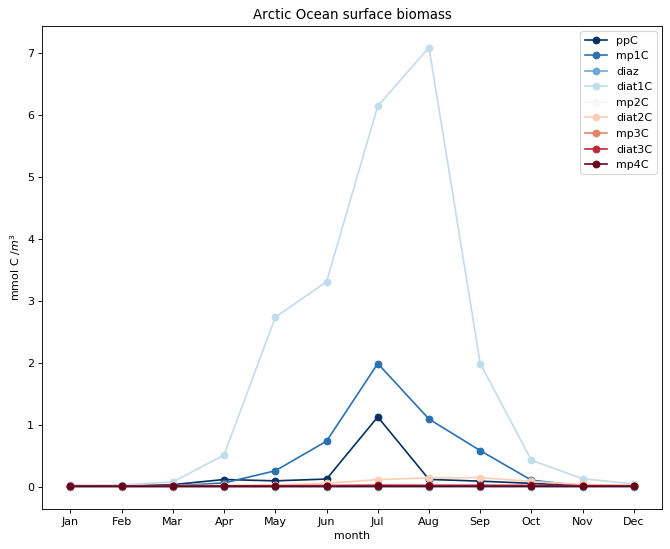

In [14]:
from matplotlib.pyplot import figure
import pylab 
cmap=mpl.cm.get_cmap('RdBu_r', 9)

fig =figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(ao_p_bmass_mn[0,:], '-o', color=cmap(0), label='ppC')
pylab.plot(ao_p_bmass_mn[1,:], '-o', color=cmap(1),label='mp1C')
pylab.plot(ao_p_bmass_mn[2,:], '-o', color=cmap(2),label='diaz')
pylab.plot(ao_p_bmass_mn[3,:], '-o', color=cmap(3),label='diat1C')
pylab.plot(ao_p_bmass_mn[4,:], '-o', color=cmap(4),label='mp2C')
pylab.plot(ao_p_bmass_mn[5,:], '-o', color=cmap(5),label='diat2C')
pylab.plot(ao_p_bmass_mn[6,:], '-o', color=cmap(6),label='mp3C')
pylab.plot(ao_p_bmass_mn[7,:], '-o', color=cmap(7),label='diat3C')
pylab.plot(ao_p_bmass_mn[8,:], '-o', color=cmap(8),label='mp4C')
pylab.legend(loc='upper right')

#plt.xticks(np.arange(0, 13, 1))
pylab.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May',
                             'Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
pylab.ylabel('mmol C /$m^3$')
pylab.xlabel('month')
pylab.title('Arctic Ocean surface biomass')
pylab.show()
fig.savefig('phyto_bmass_clim.png', dpi=300, bbox_inches='tight')

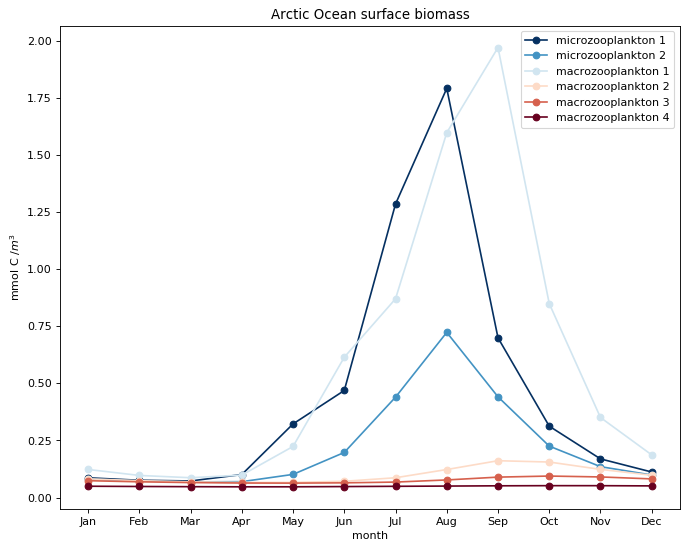

In [15]:
cmap=mpl.cm.get_cmap('RdBu_r', 6)

fig =figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(ao_z_bmass_mn[0,:], '-o', color=cmap(0),label='microzooplankton 1')
pylab.plot(ao_z_bmass_mn[1,:], '-o', color=cmap(1),label='microzooplankton 2')
pylab.plot(ao_z_bmass_mn[2,:], '-o', color=cmap(2),label='macrozooplankton 1')
pylab.plot(ao_z_bmass_mn[3,:], '-o', color=cmap(3),label='macrozooplankton 2')
pylab.plot(ao_z_bmass_mn[4,:], '-o', color=cmap(4),label='macrozooplankton 3')
pylab.plot(ao_z_bmass_mn[5,:], '-o', color=cmap(5),label='macrozooplankton 4')
pylab.legend(loc='upper right')

#plt.xticks(np.arange(0, 13, 1))
pylab.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May',
                             'Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
pylab.ylabel('mmol C /$m^3$')
pylab.xlabel('month')
pylab.title('Arctic Ocean surface biomass')
pylab.show()
fig.savefig('zoo_bmass_clim.png', dpi=300, bbox_inches='tight')

## Chlorophyll
units: $mg Chl/m^3$

In [4]:
t_chla = np.stack([ds.ppChl, ds.mp1Chl, ds.diazChl, ds.diat1Chl, ds.mp2Chl, ds.diat2Chl, ds.mp3Chl, ds.diat3Chl, ds.mp4Chl])
t_chla[t_chla<=0]=np.nan

# Carbon to Chla ratio for each of the phytoplankton groups. 
### this is important to understand the relationship between Chla, and biommass, and if this expalins the low Chla values in teh model compared to the observations, but the similar values in biomass

In [5]:
# convert units to mg C/ m^3 
phy_biomass_surf = phy_biomass_zavg_surf*.001
phy_biomass_surf[phy_biomass_surf<=0]=np.nan
# get carbon Chl, ratio
CChl_ratio_surf = phy_biomass_surf/t_chla[:,:,0,:,:]

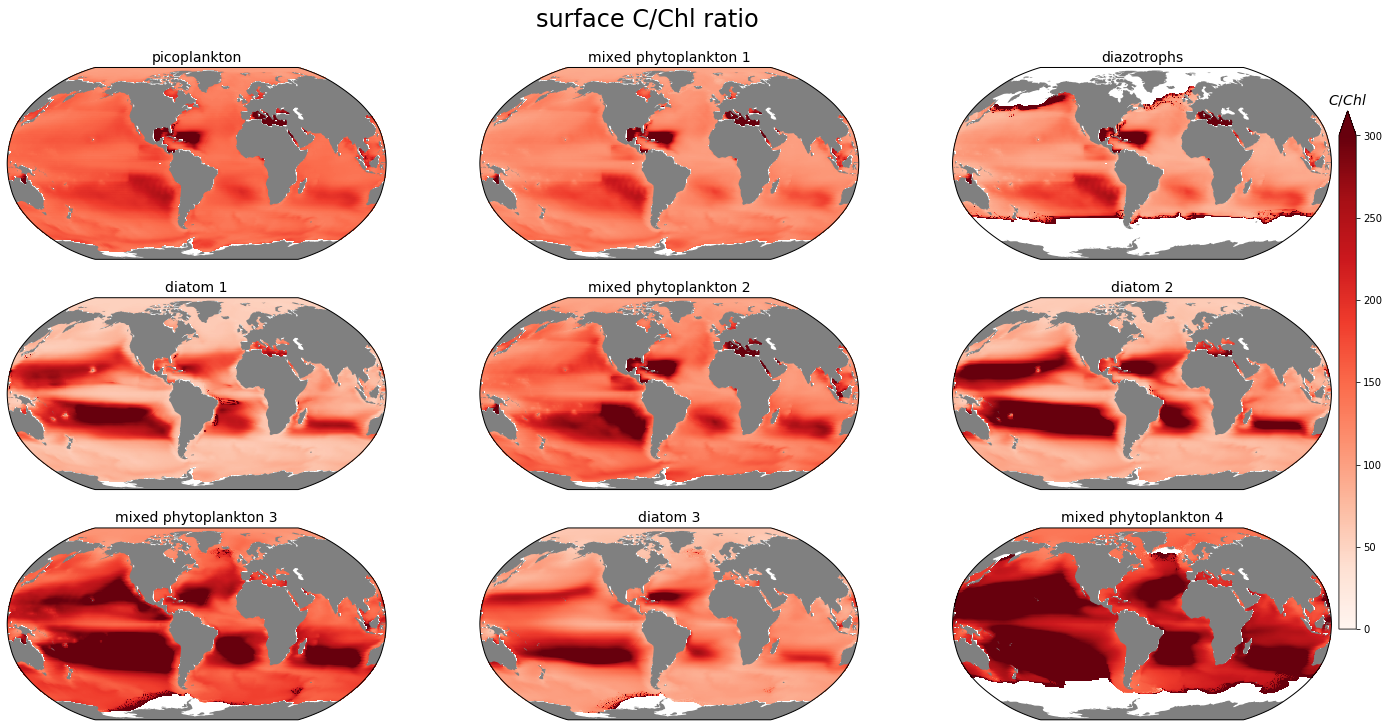

In [8]:
# convert units to mg C/ m^3 
phy_biomass_surf = phy_biomass_zavg_surf*.001

# get carbon Chl, ratio
CChl_ratio_surf = phy_biomass_surf/t_chla[:,:,0,:,:]

fig = plt.figure(figsize=(24, 12))
lat = ds.lat

# phytoplankton names 
phyto_names = ['picoplankton', 'mixed phytoplankton 1','diazotrophs','diatom 1',
              'mixed phytoplankton 2','diatom 2','mixed phytoplankton 3','diatom 3',
              'mixed phytoplankton 4']

for i in range(1,10):
    ax = fig.add_subplot(3, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.nanmean(CChl_ratio_surf[i-1,:,:,:], axis = 0), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Reds',transform=ccrs.PlateCarree(), vmin =0, vmax = 300)
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    
cb_ax = fig.add_axes([0.9, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=300), cmap='Reds'),cax=cb_ax, extend = 'max')
cbar.ax.set_title('$C/Chl$', fontsize = 14)

fig.suptitle('surface C/Chl ratio', x=0.5, y=.95,fontsize=18)
fig.savefig('C_Ch_ratio_annual_surface.png', dpi=300, bbox_inches='tight')

## create a histogram with the frequency of the ratio 

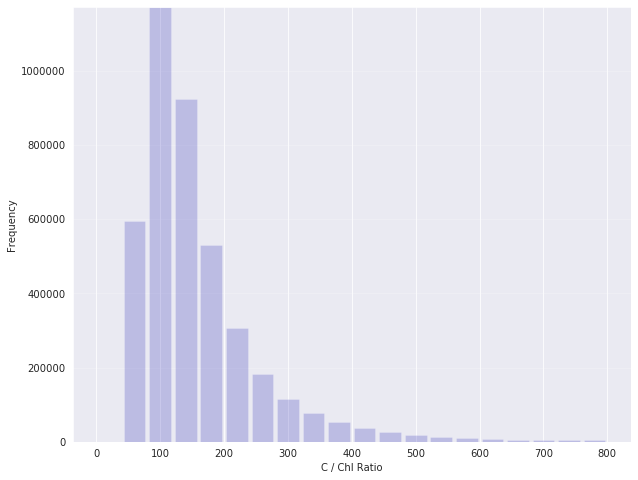

In [60]:
import matplotlib.pyplot as plt
chla = CChl_ratio_surf.reshape(12*9*180*360)
chla[chla>800]=np.nan

fig = plt.figure(figsize=(10, 8))
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=chla, bins=20, color='#0504aa',
                            alpha=0.2, rwidth=0.85)
plt.grid(axis='y', alpha=0.25)
plt.xlabel('C / Chl Ratio')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
fig.savefig('C_Ch_ratio_histogram.png', dpi=300, bbox_inches='tight')

## Zooplankton biomass at surface, for each plankton group. 

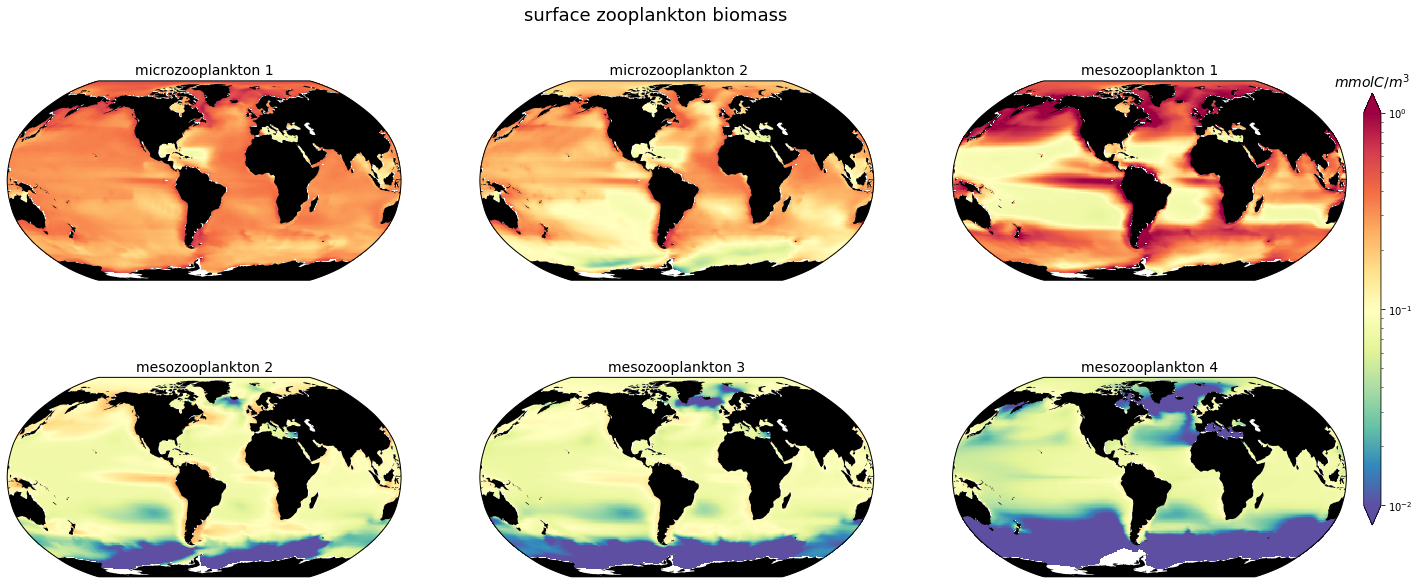

In [19]:
fig = plt.figure(figsize=(24, 10))
lat = ds.lat

# phytoplankton names 
phyto_names = ['microzooplankton 1', ' microzooplankton 2','mesozooplankton 1','mesozooplankton 2',
              'mesozooplankton 3','mesozooplankton 4']

for i in range(1,7):
    ax = fig.add_subplot(2, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.nanmean(zoo_biomass[i-1,:,0,:,:], axis = 0), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), norm=colors.LogNorm(vmin=0.01, vmax=1))
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    
cb_ax = fig.add_axes([0.91, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cf,cax=cb_ax, extend = 'both')
cbar.ax.set_title('$mmol C /m^3$', fontsize = 14)

fig.suptitle('surface zooplankton biomass', x=0.5, y=.95,fontsize=18)
fig.savefig('zoo_bmass_annual_surface_logcb.png', dpi=300, bbox_inches='tight')

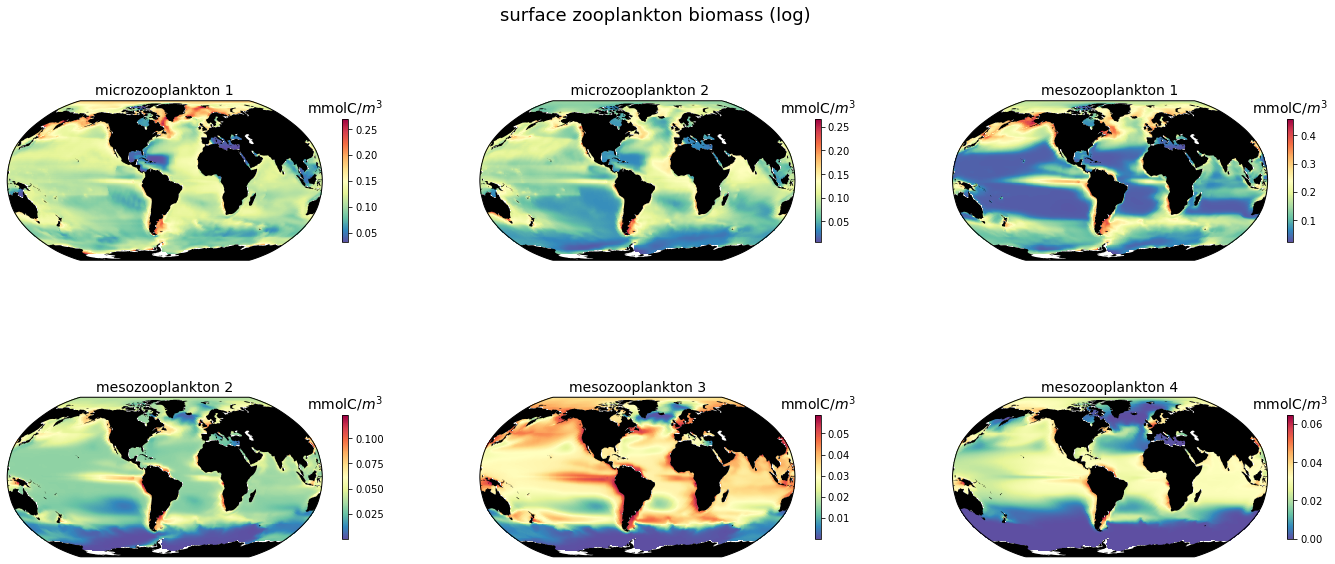

In [20]:
fig = plt.figure(figsize=(24, 10))
lat = ds.lat

# phytoplankton names 
phyto_names = ['microzooplankton 1', ' microzooplankton 2','mesozooplankton 1','mesozooplankton 2',
              'mesozooplankton 3','mesozooplankton 4']

for i in range(1,7):
    ax = fig.add_subplot(2, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.log10(np.nanmean(zoo_biomass[i-1,:,0,:,:], axis = 0)+1), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    cbar = plt.colorbar(cf, shrink=0.5)
    cbar.ax.set_title('mmolC/$m^3$', fontsize = 14)
    

fig.suptitle('surface zooplankton biomass (log)', x=0.5, y=.95,fontsize=18)
fig.savefig('zoo_bmass_annual_surface_log.png', dpi=300, bbox_inches='tight')

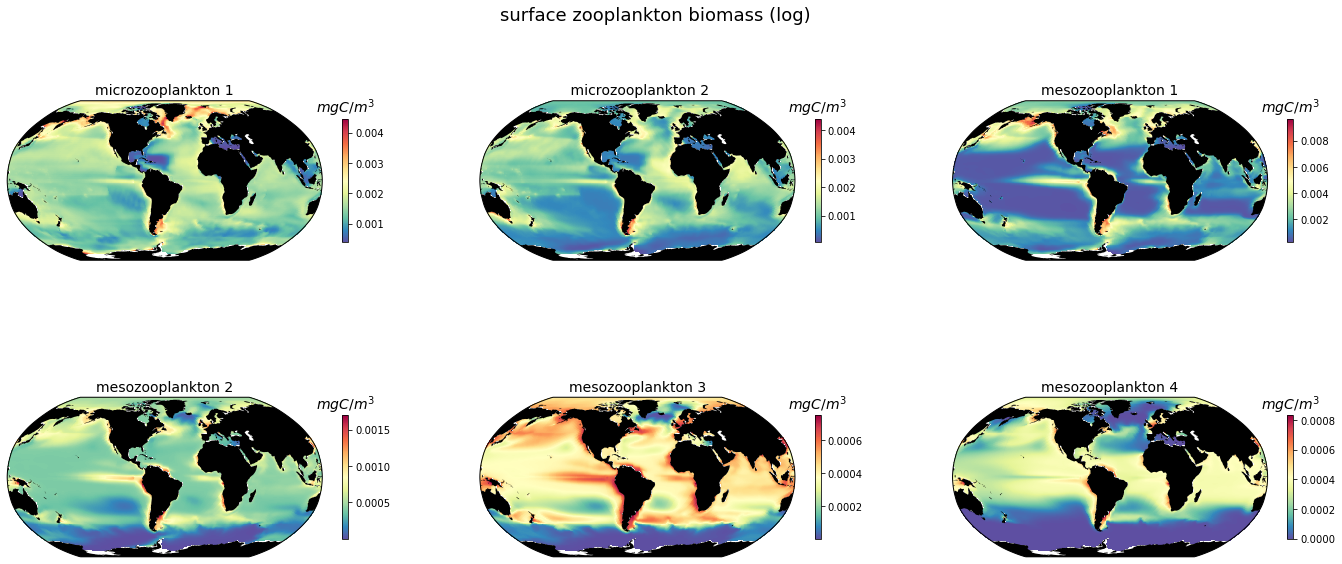

In [21]:
fig = plt.figure(figsize=(24, 10))
lat = ds.lat
zoo_biomass_zavg_surf = zoo_biomass_zavg_surf*0.001
# phytoplankton names 
phyto_names = ['microzooplankton 1', ' microzooplankton 2','mesozooplankton 1','mesozooplankton 2',
              'mesozooplankton 3','mesozooplankton 4']

for i in range(1,7):
    ax = fig.add_subplot(2, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.log10(np.nanmean(zoo_biomass_zavg_surf[i-1,:,:,:], axis = 0)+1), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    cbar = plt.colorbar(cf, shrink=0.5)
    cbar.ax.set_title('$m gC$/$m^{3}$', fontsize = 14)
    

fig.suptitle('surface zooplankton biomass (log)', x=0.5, y=.95,fontsize=18)
fig.savefig('zoo_bmass_annual_surface_log.png', dpi=300, bbox_inches='tight')

## Phytoplankton biomass at surface, for each plankton group. 

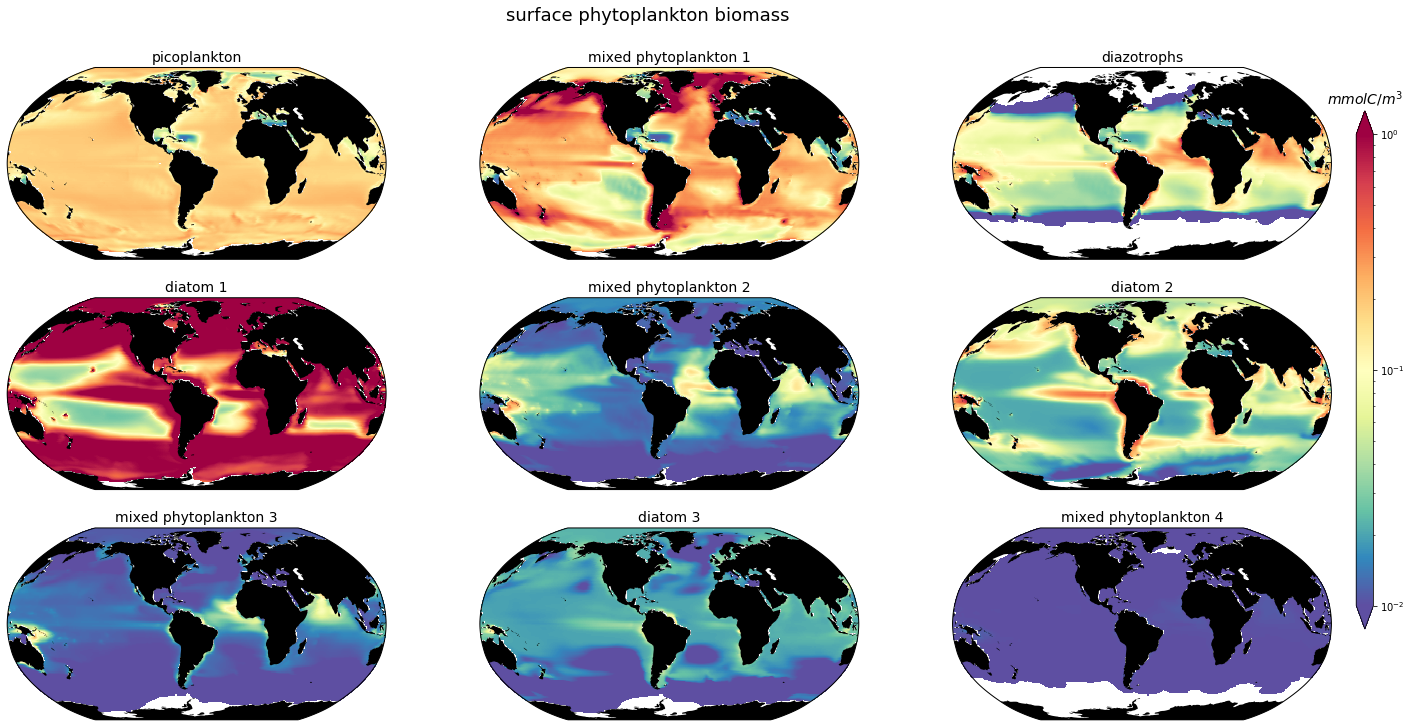

In [15]:
fig = plt.figure(figsize=(24, 12))
lat = ds.lat

# phytoplankton names 
phyto_names = ['picoplankton', 'mixed phytoplankton 1','diazotrophs','diatom 1',
              'mixed phytoplankton 2','diatom 2','mixed phytoplankton 3','diatom 3',
              'mixed phytoplankton 4']

for i in range(1,10):
    ax = fig.add_subplot(3, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.nanmean(phy_biomass[i-1,:,0,:,:], axis = 0), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',
                   transform=ccrs.PlateCarree(), norm=colors.LogNorm(vmin=0.01, vmax=1))
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    
cb_ax = fig.add_axes([0.91, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cf,cax=cb_ax, extend = 'both')
cbar.ax.set_title('$mmol C /m^3$', fontsize = 14)

fig.suptitle('surface phytoplankton biomass', x=0.5, y=.95,fontsize=18)
fig.savefig('phyto_bmass_annual_surface_logcb.png', dpi=300, bbox_inches='tight')

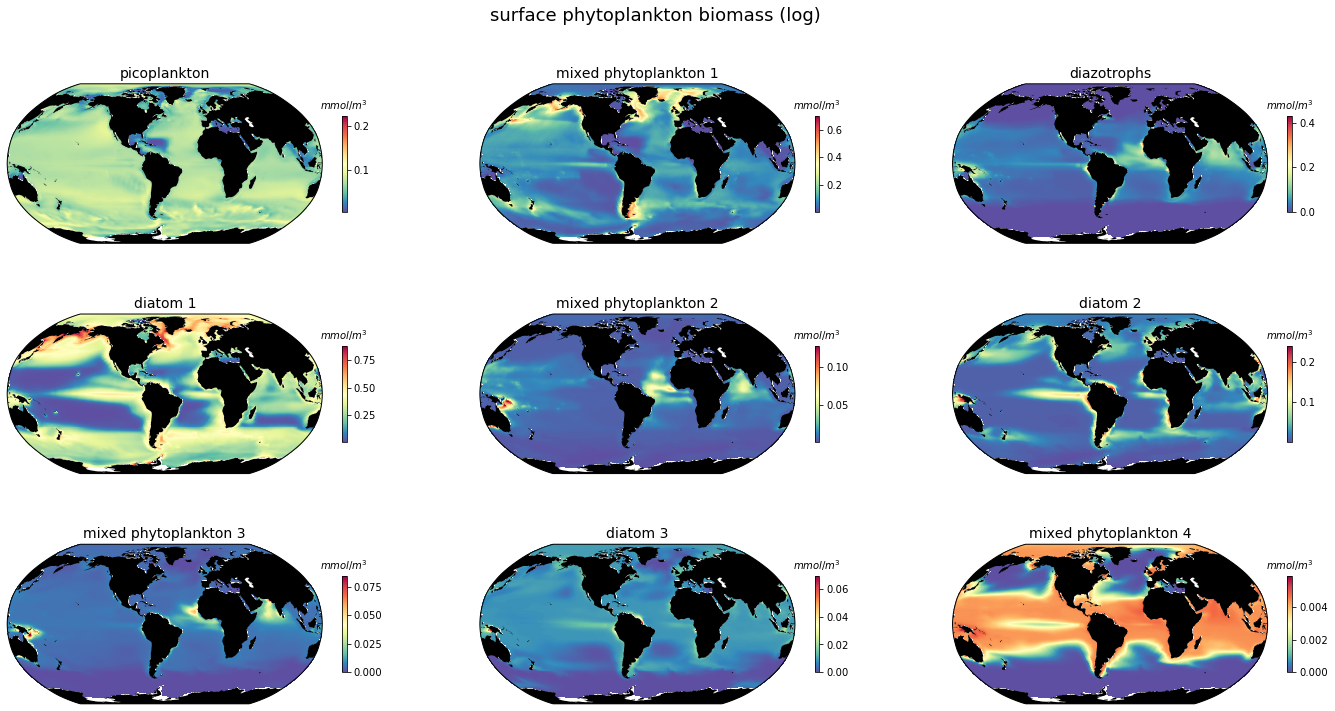

In [7]:
fig = plt.figure(figsize=(24, 12))
lat = ds.lat

# phytoplankton names 
phyto_names = ['picoplankton', 'mixed phytoplankton 1','diazotrophs','diatom 1',
              'mixed phytoplankton 2','diatom 2','mixed phytoplankton 3','diatom 3',
              'mixed phytoplankton 4']

for i in range(1,10):
    ax = fig.add_subplot(3, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.log10(np.nanmean(phy_biomass[i-1,:,0,:,:], axis = 0)+1), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    cbar = plt.colorbar(cf, shrink=0.5)
    cbar.ax.set_title('mmol C/$m^3$', fontsize = 14)


fig.suptitle('surface phytoplankton biomass (log)', x=0.5, y=.95,fontsize=18)
fig.savefig('phyto_bmass_annual_surface_log.png', dpi=300, bbox_inches='tight')

## phytoplankton biomass at surface, for each plankton group

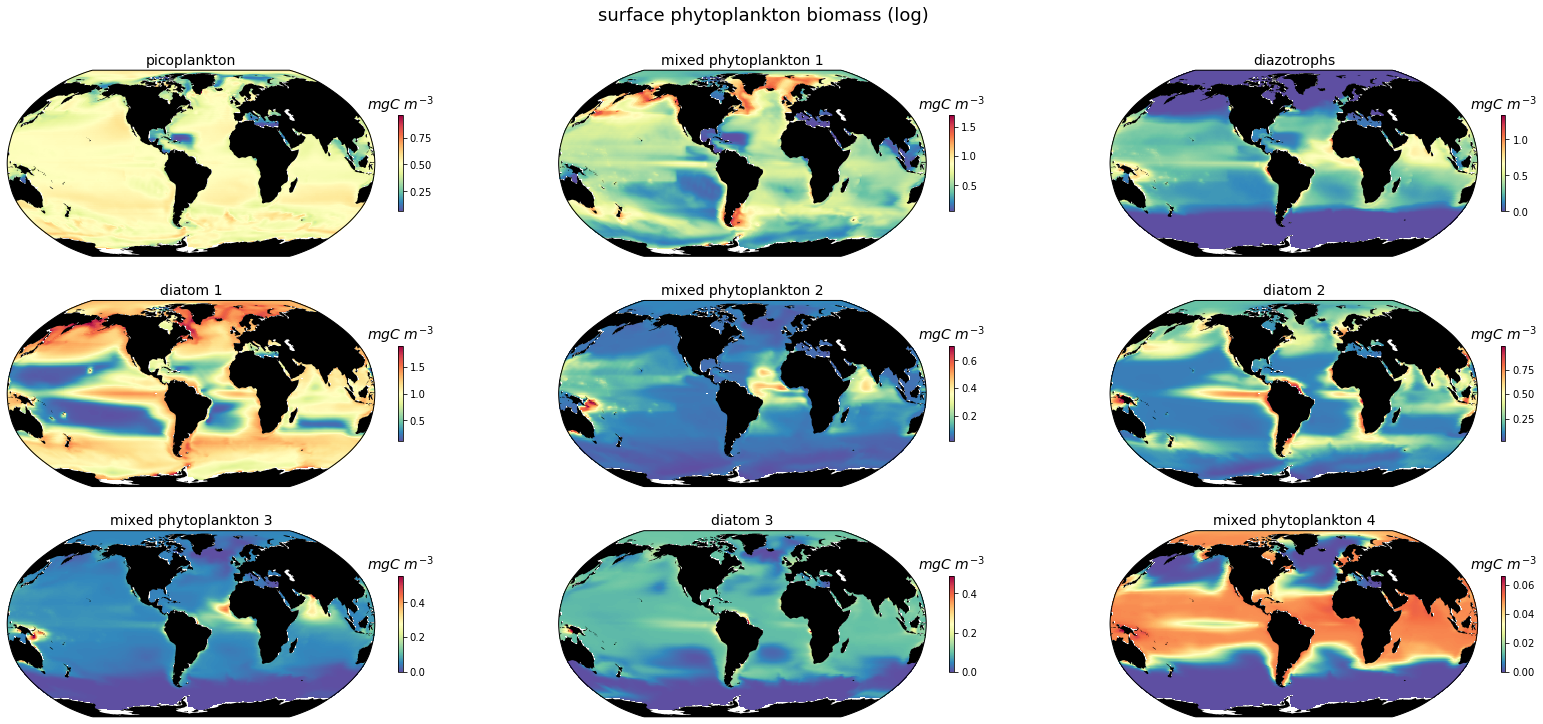

In [8]:
fig = plt.figure(figsize=(28, 12))
lat = ds.lat

# phytoplankton names 
phyto_names = ['picoplankton', 'mixed phytoplankton 1','diazotrophs','diatom 1',
              'mixed phytoplankton 2','diatom 2','mixed phytoplankton 3','diatom 3',
              'mixed phytoplankton 4']

for i in range(1,10):
    ax = fig.add_subplot(3, 3, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(np.log10(np.nanmean(phy_biomass_zavg_surf[i-1,:,:,:], axis = 0)+1), coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize=14)
    cbar = plt.colorbar(cf, shrink=0.5)
    cbar.ax.set_title('$\mu gC$ /$m^{3}$', fontsize = 14)
    
fig.suptitle('surface phytoplankton biomass (log)', x=0.5, y=.95,fontsize=18)
fig.savefig('phyto_bmass_annual_surface.png', dpi=300, bbox_inches='tight')

## biomasses by functional size
we want the biomass in units of $mg C/m^3$
to do so, we can multiply our surface biommas by 0.001 because 
$$ \frac{\mu g C}{m^3} X \frac{1mg C}{1000 \mu gC} = \frac{mgC}{m^3}$$

In [24]:
pp1 = phy_biomass_zavg_surf[0,:,:,:]*0.001
mp1 = (phy_biomass_zavg_surf[4,:,:,:]+phy_biomass_zavg_surf[5,:,:,:]+phy_biomass_zavg_surf[6,:,:,:]
       +phy_biomass_zavg_surf[7,:,:,:]+phy_biomass_zavg_surf[8,:,:,:])*0.001
np1 = (phy_biomass_zavg_surf[1,:,:,:]+phy_biomass_zavg_surf[2,:,:,:]+phy_biomass_zavg_surf[3,:,:,:])*0.001

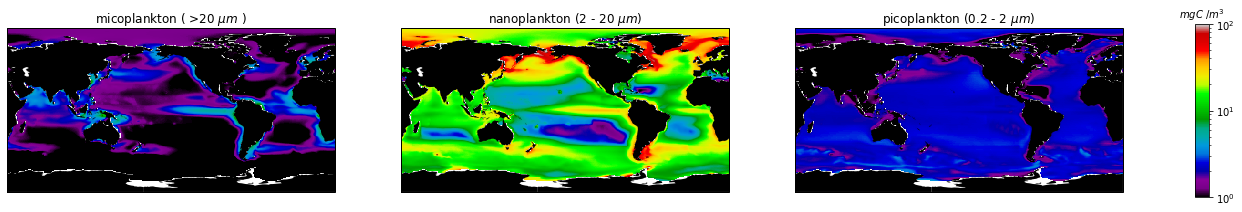

In [25]:
fig = plt.figure(figsize=(20,3))
lat = ds.lat

#microplankton
ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((mp1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(),
              norm=colors.LogNorm(vmin=1, vmax=100),cmap=cm.nipy_spectral)
ax.set_title('micoplankton ( >20 $\mu m$ )')
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

# nanoplankton
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((np1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax1.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(), 
               norm=colors.LogNorm(vmin=1, vmax=100),cmap=cm.nipy_spectral)
ax1.set_title('nanoplankton (2 - 20 $\mu m$)')
land = ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

#picoplankton
ax2 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((pp1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax2.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(), 
                norm=colors.LogNorm(vmin=1, vmax=100),cmap='nipy_spectral')
ax2.set_title('picoplankton (0.2 - 2 $\mu m$)')
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

cb_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar = fig.colorbar(cf, cax=cb_ax, shrink=0.5)
cbar.ax.set_title('$mgC$ /$m^3$', fontsize = 10)

fig.savefig('biomass_size_fraction_surface_annual.png', dpi=600, bbox_inches='tight')

Text(0.5, 1.0, '$mgC$ /$m^3$')

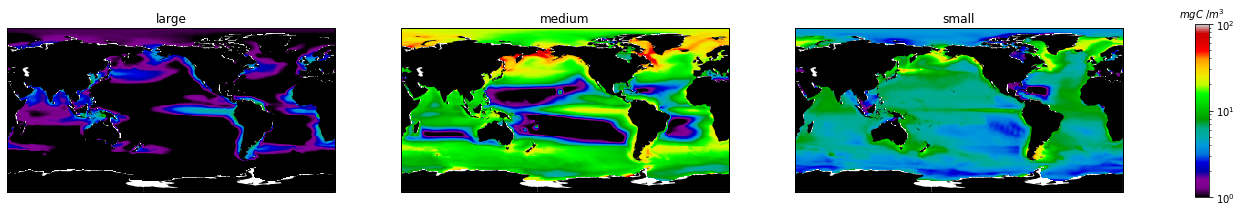

In [22]:
pp1 = (phy_biomass_zavg_surf[0,:,:,:]+ phy_biomass_zavg_surf[1,:,:,:]+phy_biomass_zavg_surf[2,:,:,:])*0.001
mp1 = (phy_biomass_zavg_surf[6,:,:,:]+phy_biomass_zavg_surf[7,:,:,:]+phy_biomass_zavg_surf[8,:,:,:]+phy_biomass_zavg_surf[5,:,:,:])*0.001
np1 = (phy_biomass_zavg_surf[4,:,:,:]+phy_biomass_zavg_surf[3,:,:,:])*0.001

fig = plt.figure(figsize=(20,3))
lat = ds.lat

#microplankton
ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((mp1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(),
              norm=colors.LogNorm(vmin=1, vmax=100),cmap=cm.nipy_spectral)
ax.set_title('large')
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

# nanoplankton
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((np1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax1.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(), 
               norm=colors.LogNorm(vmin=1, vmax=100),cmap=cm.nipy_spectral)
ax1.set_title('medium')
land = ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

#picoplankton
ax2 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree(central_longitude=210.0))
phyto, lon = add_cyclic_point(np.nanmean((pp1[:,:,:]), axis = 0), coord=ds.lon, axis=1)
cf = ax2.pcolor(lon, lat, phyto,transform=ccrs.PlateCarree(), 
                norm=colors.LogNorm(vmin=1, vmax=100),cmap='nipy_spectral')
ax2.set_title('small')
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

cb_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar = fig.colorbar(cf, cax=cb_ax, shrink=0.5)
cbar.ax.set_title('$mgC$ /$m^3$', fontsize = 10)

In [ ]:
fig.savefig('biomass_size_fraction_surface_annual_3_3_3.png', dpi=600, bbox_inches='tight')

<img src="Figs_Question2/plankton1.png" alt="Drawing" style="width: 1000px;"/>